# **Comparative Analysis of Speech emotion recognition**

#### Why we chose SVM as one of our models to do the comparative analysis
- https://ieeexplore.ieee.org/document/6512793?utm_source=chatgpt.com

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
# Define dataset directory
dataset_path = r'F:\CompAnalysis\RAVDESS'

# Function to load all audio file paths
def load_ravdess_files(dataset_path):
    audio_files = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):  # Ensure only .wav files are considered
                audio_files.append(os.path.join(root, file))
    return audio_files

# Load all file paths
ravdess_files = load_ravdess_files(dataset_path)

# Load a sample file (first file)
sample_file = ravdess_files[0]  # Change index if needed
signal, sr = librosa.load(sample_file, sr=None)  # Load with original sampling rate

target_sr = 16000
if sr != target_sr:
    signal = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)
    sr = target_sr  
    
print(f"Sampling Rate: {target_sr} Hz")
print(f"Audio Length: {len(signal) / sr:.2f} seconds")


Sampling Rate: 16000 Hz
Audio Length: 3.30 seconds


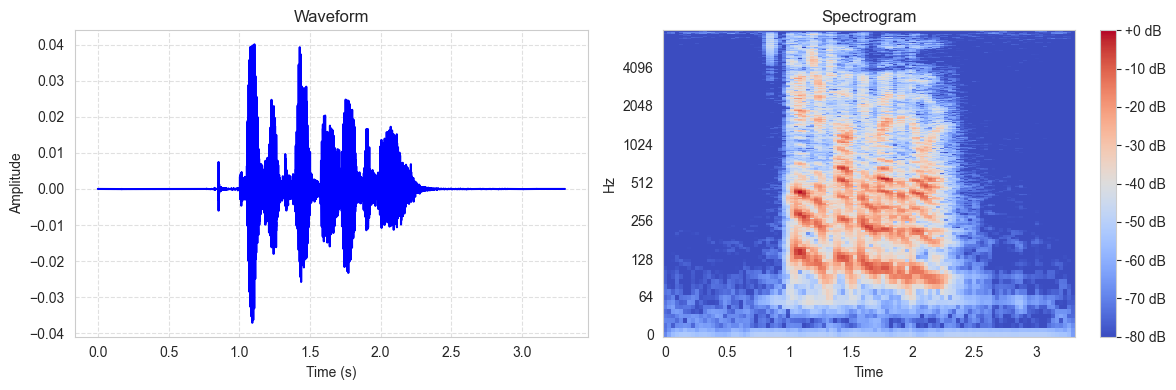

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Load the audio file (assuming 'sample_file' is already defined)
signal, sr = librosa.load(sample_file, sr=16000)  # Ensure it's resampled to 16kHz

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot waveform
axes[0].plot(np.linspace(0, len(signal) / sr, len(signal)), signal, color='b')
axes[0].set_title("Waveform")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, linestyle='--', alpha=0.6)

# Compute and plot spectrogram 
D = np.abs(librosa.stft(signal))  # Compute STFT magnitude
D_db = librosa.amplitude_to_db(D, ref=np.max)  # Convert to decibels

img = librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm', ax=axes[1])
axes[1].set_title("Spectrogram")
fig.colorbar(img, ax=axes[1], format='%+2.0f dB')

# Display the plots
plt.tight_layout()
plt.show()


In [4]:
def vad_trim(signal, sr):
    """Applies VAD trimming using adaptive thresholding."""
    rms_energy = librosa.feature.rms(y=signal, frame_length=1024, hop_length=512)[0]
    threshold = np.median(rms_energy) * 2  # Adaptive threshold
    voiced_frames = rms_energy > threshold

    if np.any(voiced_frames):
        non_silent_indices = np.where(voiced_frames)[0]
        start = max(0, non_silent_indices[0] * 512)  # Convert frame index to sample index
        end = min(len(signal), non_silent_indices[-1] * 512)
        signal = signal[start:end]  # Trimmed signal

    return signal

# Load and process RAVDESS dataset
ravdess_files = load_ravdess_files(dataset_path)
vad_audio_data = {}

for file in ravdess_files:
    signal, sr = librosa.load(file, sr=16000)  
    trimmed_signal = vad_trim(signal, sr) 
    vad_audio_data[file] = (trimmed_signal, sr)

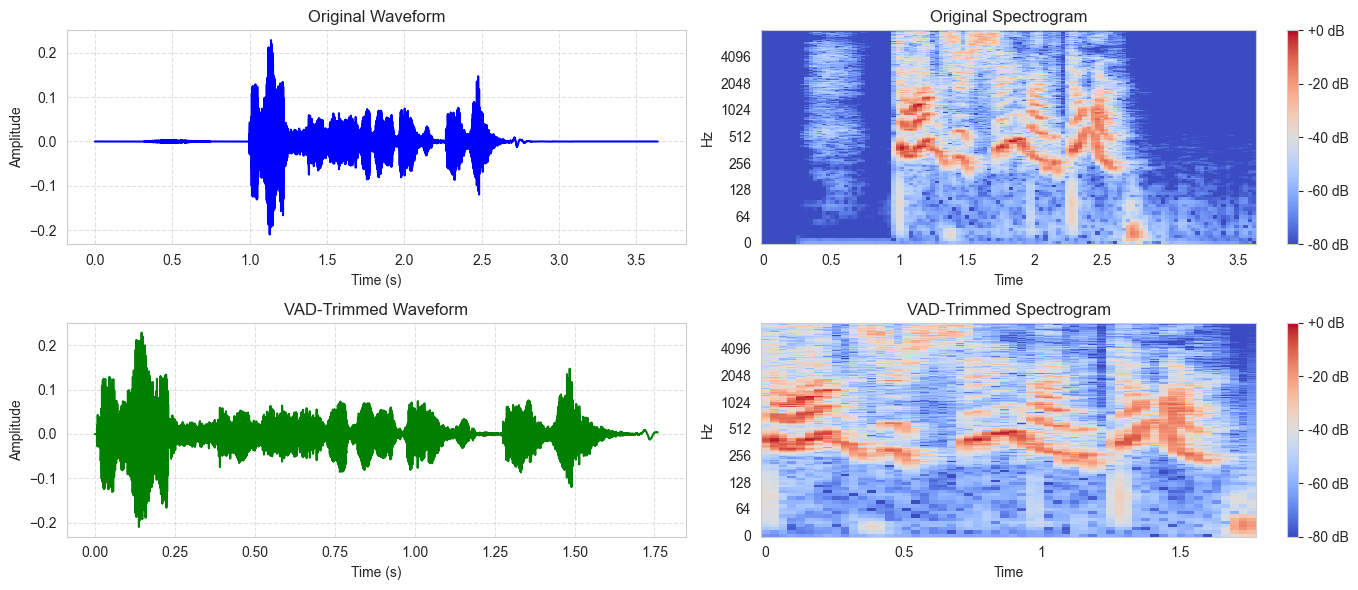

In [5]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

axes[0, 0].plot(np.linspace(0, len(signal) / sr, len(signal)), signal, color='b')
axes[0, 0].set_title("Original Waveform")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

axes[1, 0].plot(np.linspace(0, len(trimmed_signal) / sr, len(trimmed_signal)), trimmed_signal, color='g')
axes[1, 0].set_title("VAD-Trimmed Waveform")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# Compute and plot original spectrogram 
D_orig = np.abs(librosa.stft(signal)) 
D_orig_db = librosa.amplitude_to_db(D_orig, ref=np.max) 
img1 = librosa.display.specshow(D_orig_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title("Original Spectrogram")
fig.colorbar(img1, ax=axes[0, 1], format='%+2.0f dB')

# Compute and plot preprocessed spectrogram
D_trimmed = np.abs(librosa.stft(trimmed_signal))  
D_trimmed_db = librosa.amplitude_to_db(D_trimmed, ref=np.max) 

img2 = librosa.display.specshow(D_trimmed_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title("VAD-Trimmed Spectrogram")
fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB')
plt.tight_layout()
plt.show()


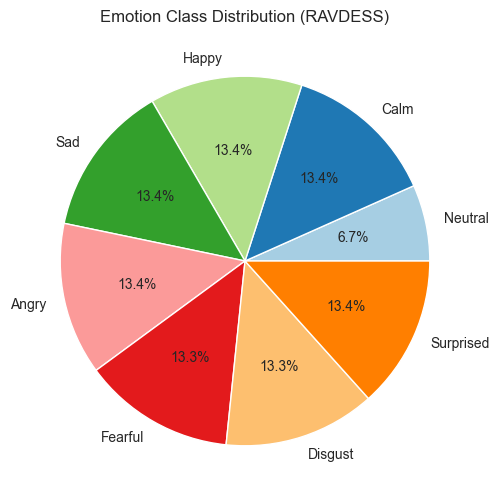

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Define dataset path
dataset_path = r'F:\CompAnalysis\RAVDESS'

# Emotion mapping based on filename convention
emotion_map = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

# Extract labels from filenames
labels_list = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            emotion_id = file.split("-")[2]  # Extract the 3rd part of filename
            emotion = emotion_map.get(emotion_id, "Unknown")  # Map to emotion
            labels_list.append(emotion)

# Count occurrences of each class
label_counts = Counter(labels_list)

# Plot class distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Emotion Class Distribution (RAVDESS)")
plt.show()


### Feature Extraction - extracting multiple features and saving them

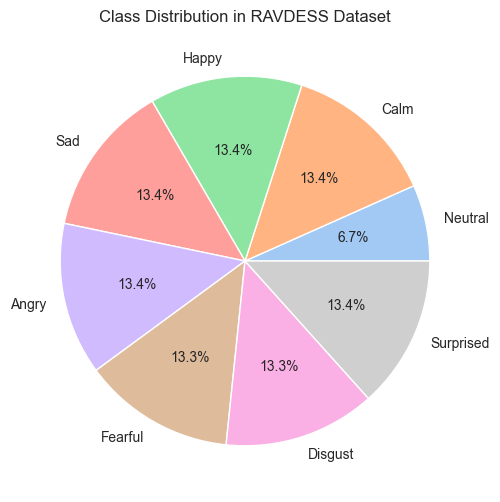

Features (MFCC 40, RMS, ZCR) extracted, normalized, and saved!


In [7]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Define dataset and features paths
dataset_path = r'F:\CompAnalysis\RAVDESS'
features_path = os.path.join(dataset_path, 'features')
os.makedirs(features_path, exist_ok=True)

# RAVDESS Emotion Label Mapping
emotion_map = {
    1: "Neutral",
    2: "Calm",
    3: "Happy",
    4: "Sad",
    5: "Angry",
    6: "Fearful",
    7: "Disgust",
    8: "Surprised"
}

# Set fixed length for padding/truncation
FIXED_LENGTH = 200  

def pad_or_truncate(feature, target_length=FIXED_LENGTH):
    """Pads or truncates a feature to a fixed length."""
    if feature.shape[0] > target_length:
        return feature[:target_length]  # Truncate
    elif feature.shape[0] < target_length:
        pad_width = target_length - feature.shape[0]
        return np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')  # Pad with zeros
    return feature

def extract_features(file_path):
    """Extract MFCC 40, RMS, and ZCR features and ensure uniform shape"""
    signal, sr = librosa.load(file_path, sr=16000)

    # Extract features
    mfcc_40 = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    rms = librosa.feature.rms(y=signal)
    zcr = librosa.feature.zero_crossing_rate(y=signal)

    # Transpose to (time_steps, feature_dim)
    mfcc_40 = pad_or_truncate(mfcc_40.T)
    rms = pad_or_truncate(rms.T)
    zcr = pad_or_truncate(zcr.T)

    # Concatenate features along feature axis
    combined_features = np.concatenate((mfcc_40, rms, zcr), axis=1)  # Shape: (time_steps, 42)

    return combined_features

# Process all audio files
audio_files = [os.path.join(root, f) for root, _, files in os.walk(dataset_path) for f in files if f.endswith(".wav")]

features_list, labels_list, emotion_names = [], [], []

for file in audio_files:
    try:
        # Extract label from filename
        label = int(os.path.basename(file).split("-")[2])  # Extracts the 3rd part as emotion label
        emotion_label = emotion_map[label]  # Map to emotion class
        emotion_names.append(emotion_label)  # Store class name

        # Extract features
        features = extract_features(file)
        features_list.append(features)
        labels_list.append(label)

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert to numpy arrays
features_array = np.stack(features_list)  # Shape: (num_samples, time_steps, 42)
labels_array = np.array(labels_list, dtype=np.int64)  # Shape: (num_samples,)

# Plot Class Distribution Pie Chart
emotion_counts = Counter(emotion_names)
plt.figure(figsize=(8, 6))
plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Class Distribution in RAVDESS Dataset")
plt.show()

# Normalize across samples
scaler = StandardScaler()
features_array = scaler.fit_transform(features_array.reshape(features_array.shape[0], -1)).reshape(features_array.shape)

# Save features and labels
np.save(os.path.join(features_path, "features.npy"), features_array)
np.save(os.path.join(features_path, "labels.npy"), labels_array)

print("Features (MFCC 40, RMS, ZCR) extracted, normalized, and saved!")


### Training the model with MFCC 13 feature set

Training XGBoost: 100%|██████████| 1/1 [00:30<00:00, 30.92s/it]
c:\Users\preet\anaconda3\envs\pytorchenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy on RAVDESS: 53.12%

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.42      0.37        19
           1       0.54      0.74      0.62        39
           2       0.52      0.37      0.43        38
           3       0.41      0.41      0.41        39
           4       0.58      0.67      0.62        39
           5       0.84      0.42      0.56        38
           6       0.56      0.58      0.57        38
           7       0.54      0.58      0.56        38

    accuracy                           0.53       288
   macro avg       0.54      0.52      0.52       288
weighted avg       0.55      0.53      0.53       288



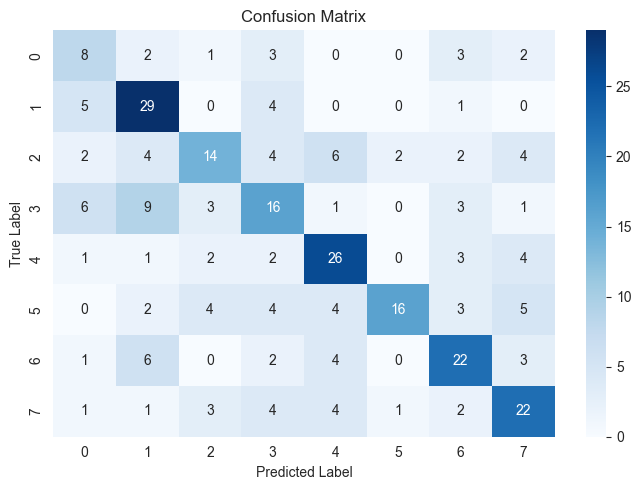

In [10]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# 🔧 Optional: Enable GPU (if supported)
os.environ["XGB_FORCE_GPU"] = "1"

# 📁 Load features and labels
features_path = r"F:\CompAnalysis\RAVDESS\features"
mfcc_features = np.load(os.path.join(features_path, "mfcc_13.npy"))  # [samples, time_steps, 13]
labels = np.load(os.path.join(features_path, "labels.npy"))          # [samples,]

# 🎯 Flatten MFCC for XGBoost (must be 2D: [samples, features])
X = mfcc_features.reshape(mfcc_features.shape[0], -1)
# Shift labels to start from 0 (from [1–8] → [0–7])
y = labels - 1


# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🔍 Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Best Hyperparameters (you can tune these with Optuna/GridSearchCV later)
best_params = {
    'subsample': 1.0,
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.05,
    'gamma': 0.5,
    'colsample_bytree': 0.8
}

# ⚙️ Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    tree_method="hist",  # Use 'gpu_hist' if supported, else 'hist'
    device='cuda',
    random_state=0,
    verbosity=1
)

# 🚀 Train the Model
with tqdm(total=1, desc="Training XGBoost") as pbar:
    xgb_model.fit(X_train_scaled, y_train)
    pbar.update(1)

# ✅ Predict
y_pred = xgb_model.predict(X_test_scaled)

# 📊 Results
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy on RAVDESS: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 🌀 Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### Training the model with MFCC 40 feature set

Training XGBoost: 100%|██████████| 1/1 [01:20<00:00, 80.79s/it]


✅ XGBoost Accuracy on RAVDESS: 48.26%

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.26      0.30        19
           1       0.46      0.72      0.56        39
           2       0.40      0.32      0.35        38
           3       0.39      0.38      0.39        39
           4       0.59      0.62      0.60        39
           5       0.50      0.32      0.39        38
           6       0.49      0.47      0.48        38
           7       0.58      0.66      0.62        38

    accuracy                           0.48       288
   macro avg       0.47      0.47      0.46       288
weighted avg       0.48      0.48      0.47       288



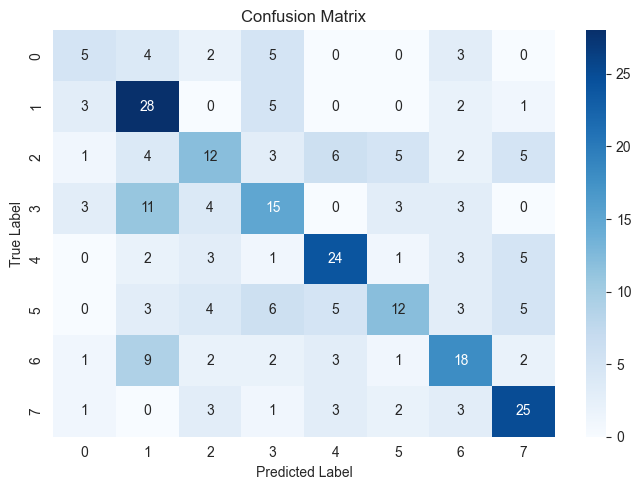

In [11]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# 🔧 Optional: Enable GPU (if supported)
os.environ["XGB_FORCE_GPU"] = "1"

# 📁 Load features and labels
features_path = r"F:\CompAnalysis\RAVDESS\features"
mfcc_features = np.load(os.path.join(features_path, "mfcc_40.npy"))  # [samples, time_steps, 13]
labels = np.load(os.path.join(features_path, "labels.npy"))          # [samples,]

# 🎯 Flatten MFCC for XGBoost (must be 2D: [samples, features])
X = mfcc_features.reshape(mfcc_features.shape[0], -1)
# Shift labels to start from 0 (from [1–8] → [0–7])
y = labels - 1


# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🔍 Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Best Hyperparameters (you can tune these with Optuna/GridSearchCV later)
best_params = {
    'subsample': 1.0,
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.05,
    'gamma': 0.5,
    'colsample_bytree': 0.8
}

# ⚙️ Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    tree_method="hist",  # Use 'gpu_hist' if supported, else 'hist'
    device='cuda',
    random_state=0,
    verbosity=1
)

# 🚀 Train the Model
with tqdm(total=1, desc="Training XGBoost") as pbar:
    xgb_model.fit(X_train_scaled, y_train)
    pbar.update(1)

# ✅ Predict
y_pred = xgb_model.predict(X_test_scaled)

# 📊 Results
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy on RAVDESS: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 🌀 Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### Training the code with MFCC DD feature set

Training XGBoost: 100%|██████████| 1/1 [01:19<00:00, 79.26s/it]



✅ XGBoost Accuracy on RAVDESS (MFCC+Δ+ΔΔ): 48.26%

📋 Classification Report:
               precision    recall  f1-score   support

           0     0.2692    0.3684    0.3111        19
           1     0.4906    0.6667    0.5652        39
           2     0.5185    0.3684    0.4308        38
           3     0.3243    0.3077    0.3158        39
           4     0.5581    0.6154    0.5854        39
           5     0.6364    0.3684    0.4667        38
           6     0.5278    0.5000    0.5135        38
           7     0.5227    0.6053    0.5610        38

    accuracy                         0.4826       288
   macro avg     0.4810    0.4750    0.4687       288
weighted avg     0.4947    0.4826    0.4793       288



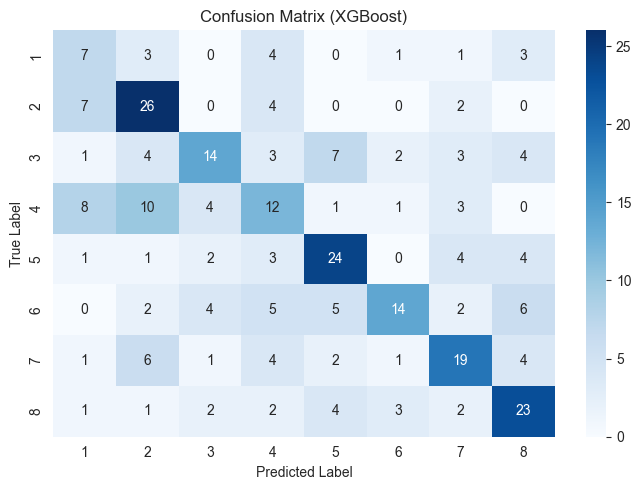

In [15]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# ⚙️ Optional: Enable GPU
os.environ["XGB_FORCE_GPU"] = "1"

# 📂 Load Features and Labels
features_path = r'F:\CompAnalysis\RAVDESS\features'
mfcc_13 = np.load(os.path.join(features_path, "mfcc_13.npy"))        # [num_samples, time_steps, 13]
mfcc_delta = np.load(os.path.join(features_path, "mfcc_delta.npy")) # [num_samples, time_steps, 13]
mfcc_dd = np.load(os.path.join(features_path, "mfcc_dd.npy"))       # [num_samples, time_steps, 13]
labels = np.load(os.path.join(features_path, "labels.npy"))         # [num_samples]

# 🔄 Flatten and Concatenate MFCC + Δ + ΔΔ → shape: [samples, features]
num_samples, time_steps, num_coeffs = mfcc_13.shape
mfcc_13_flat = mfcc_13.reshape(num_samples, -1)
mfcc_delta_flat = mfcc_delta.reshape(num_samples, -1)
mfcc_dd_flat = mfcc_dd.reshape(num_samples, -1)
X = np.hstack([mfcc_13_flat, mfcc_delta_flat, mfcc_dd_flat])

# 🎯 Shift labels from [1–8] ➝ [0–7]
y = labels - 1

# 🔀 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🔍 Feature Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# 🔧 XGBoost Hyperparameters
best_params = {
    'subsample': 1.0,
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.05,
    'gamma': 0.5,
    'colsample_bytree': 0.8
}

# 🧠 Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softmax',
    num_class=8,  # classes are now [0–7]
    eval_metric='mlogloss',
    tree_method='hist',  # or 'gpu_hist' if you have GPU support
    device='cuda',
    random_state=0,
    verbosity=1
)

# 🚀 Train Model
with tqdm(total=1, desc="Training XGBoost") as pbar:
    xgb_model.fit(X_train_scaled, y_train)
    pbar.update(1)

# 🔮 Predict
y_pred = xgb_model.predict(X_test_scaled)

# ✅ Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ XGBoost Accuracy on RAVDESS (MFCC+Δ+ΔΔ): {accuracy * 100:.2f}%")
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 📊 Confusion Matrix with class labels from 1–8
plt.figure(figsize=(7, 5))
tick_labels = np.arange(1, 9)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()


Training XGBoost: 100%|██████████| 1/1 [01:22<00:00, 82.61s/it]


✅ XGBoost Accuracy on RAVDESS: 49.65%

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.26      0.29        19
           1       0.48      0.72      0.58        39
           2       0.48      0.29      0.36        38
           3       0.42      0.41      0.42        39
           4       0.57      0.67      0.61        39
           5       0.43      0.32      0.36        38
           6       0.56      0.63      0.59        38
           7       0.58      0.55      0.57        38

    accuracy                           0.50       288
   macro avg       0.48      0.48      0.47       288
weighted avg       0.49      0.50      0.48       288



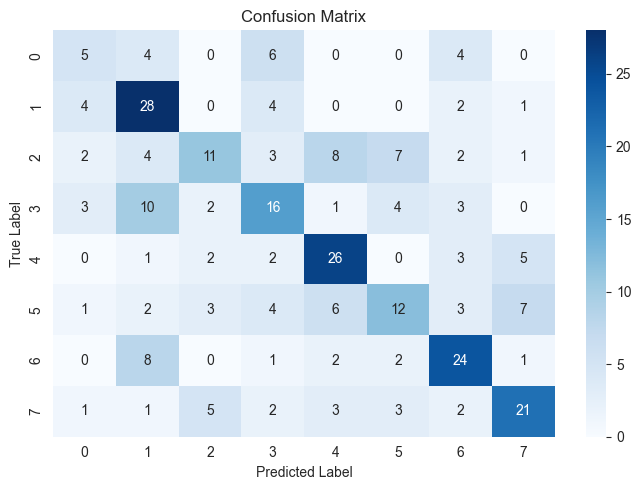

In [14]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# 🔧 Optional: Enable GPU (if supported)
os.environ["XGB_FORCE_GPU"] = "1"

# 📁 Load features and labels
features_path = r"F:\CompAnalysis\RAVDESS\features"
mfcc_features = np.load(os.path.join(features_path, "features.npy"))  # [samples, time_steps, 13]
labels = np.load(os.path.join(features_path, "labels.npy"))          # [samples,]

# 🎯 Flatten MFCC for XGBoost (must be 2D: [samples, features])
X = mfcc_features.reshape(mfcc_features.shape[0], -1)
# Shift labels to start from 0 (from [1–8] → [0–7])
y = labels - 1


# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🔍 Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Best Hyperparameters (you can tune these with Optuna/GridSearchCV later)
best_params = {
    'subsample': 1.0,
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.05,
    'gamma': 0.5,
    'colsample_bytree': 0.8
}

# ⚙️ Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    tree_method="hist",  # Use 'gpu_hist' if supported, else 'hist'
    device='cuda',
    random_state=0,
    verbosity=1
)

# 🚀 Train the Model
with tqdm(total=1, desc="Training XGBoost") as pbar:
    xgb_model.fit(X_train_scaled, y_train)
    pbar.update(1)

# ✅ Predict
y_pred = xgb_model.predict(X_test_scaled)

# 📊 Results
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy on RAVDESS: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 🌀 Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
